### Loading the super-tensor and creating the temporal networks

To load the super tensor and compute the netowork measures on the data the class __temporal_network__ is used.

In [1]:
import numpy                 as     np
import matplotlib.pyplot     as     plt
from   GDa.temporal_network  import temporal_network
from   tqdm                  import tqdm

To instantiate the __temporal_network__ we have to supply the monkey name, the session, and date to its constructor.

In [2]:
# Instantiating a temporal network object
net =  temporal_network(monkey='lucy', date=150128, session=1)

When instantiated the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time]. So far we are using the following bands:

- $\theta$  = [4,8[    Hz;
- $\alpha$  = [8,15[   Hz;
- $\beta$   = [15,30[  Hz;
- $\gamma$  = [30,60[  Hz;

Next, we can plot the supertensor (for better visualization bellow we plot only for ten trials):

Text(0.5, 0, 'Time (s)')

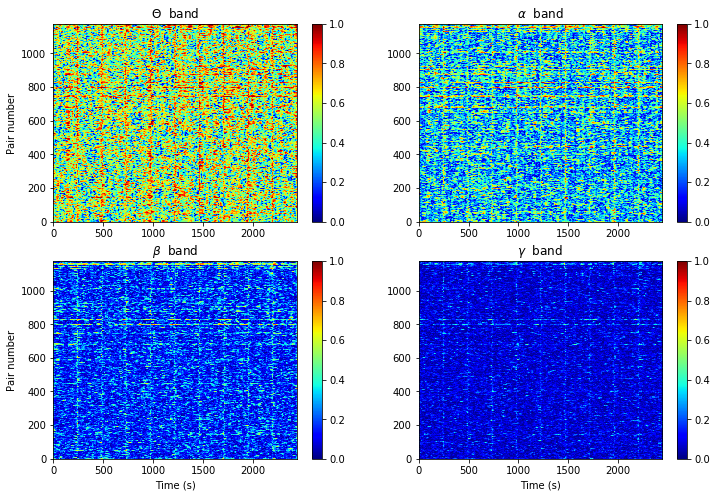

In [3]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.super_tensor[:,0,:2440], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\Theta$  band')
plt.ylabel('Pair number')
plt.subplot(2,2,2)
plt.imshow(net.super_tensor[:,1,:2440], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(net.super_tensor[:,2,:2440], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\beta$  band')
plt.ylabel('Pair number')
plt.xlabel('Time (s)')
plt.subplot(2,2,4)
plt.imshow(net.super_tensor[:,3,:2440], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\gamma$  band')
plt.xlabel('Time (s)')

The super tensor can be converted to a adjacency tensor by using the method __convert_to_adjacency__:

In [4]:
net.convert_to_adjacency()

The adjacency tensor has dimensions $[nC, nC,bands,Trials*time]$, where $nC$ is the number of channels, and bands the number of frequency bands.

In [5]:
print('Adjacency tensor shape = ' + str( net.A.shape) )

Adjacency tensor shape = (49, 49, 4, 131760)


Let's plot one layer of the adjacency tensor below:

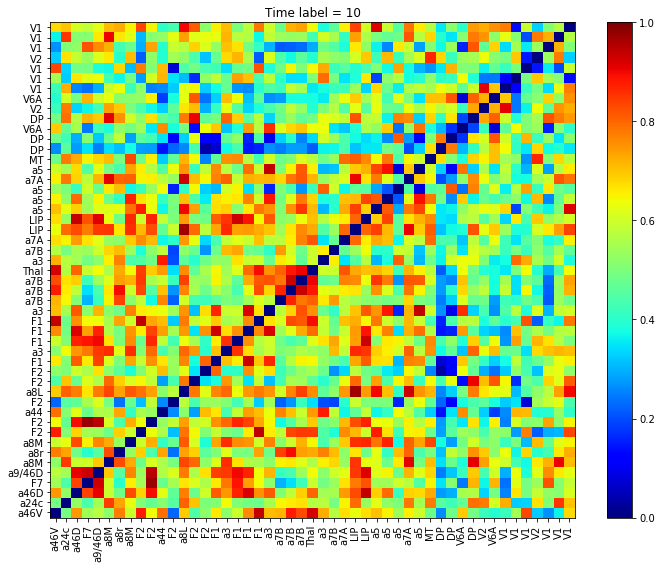

In [6]:
plt.figure(figsize=(10,8))
plt.imshow(net.A[:,:,0,10]+net.A[:,:,0,10].T,aspect='auto',cmap='jet',origin='lower', vmin=0, vmax=1);plt.colorbar()
plt.title('Time label = ' + str(10))
plt.xticks(range(49), net.session_info['areas'], rotation = 90)
plt.yticks(range(49), net.session_info['areas'])
plt.tight_layout()

In [7]:
net.compute_nodes_strength()

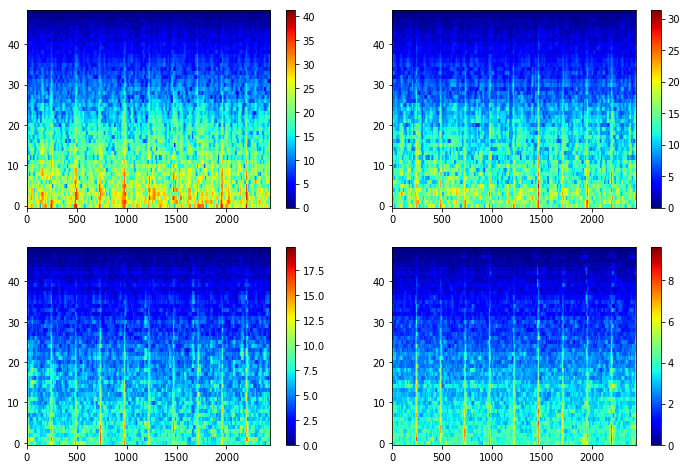

In [8]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.node_degree[:,0,:2440], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(net.node_degree[:,1,:2440], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(net.node_degree[:,2,:2440], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(net.node_degree[:,3,:2440], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [9]:
net.create_stages_time_grid()

In [10]:
stages = np.zeros([net.session_info['nT'],len(net.tarray)])
ii     = [net.t_baseline.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_cue.reshape(net.session_info['nT'],len(net.tarray)), 
          net.t_delay.reshape(net.session_info['nT'],len(net.tarray)),
          net.t_match.reshape(net.session_info['nT'],len(net.tarray))]
for i in range(4):
    stages = stages - i * ii[i]

Text(0.5, 0, 'Time')

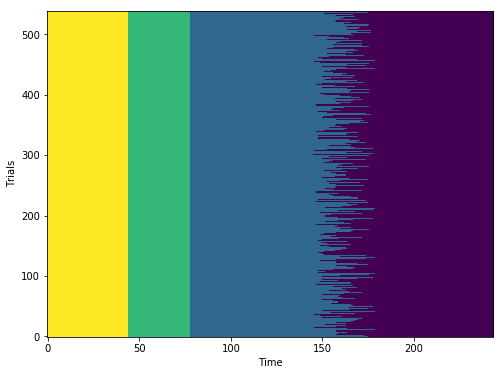

In [11]:
plt.figure(figsize = (8,6))
plt.imshow(stages, aspect='auto',cmap='viridis',origin='lower')
plt.ylabel('Trials')
plt.xlabel('Time')

In [12]:
net.super_tensor.shape

(1176, 4, 131760)

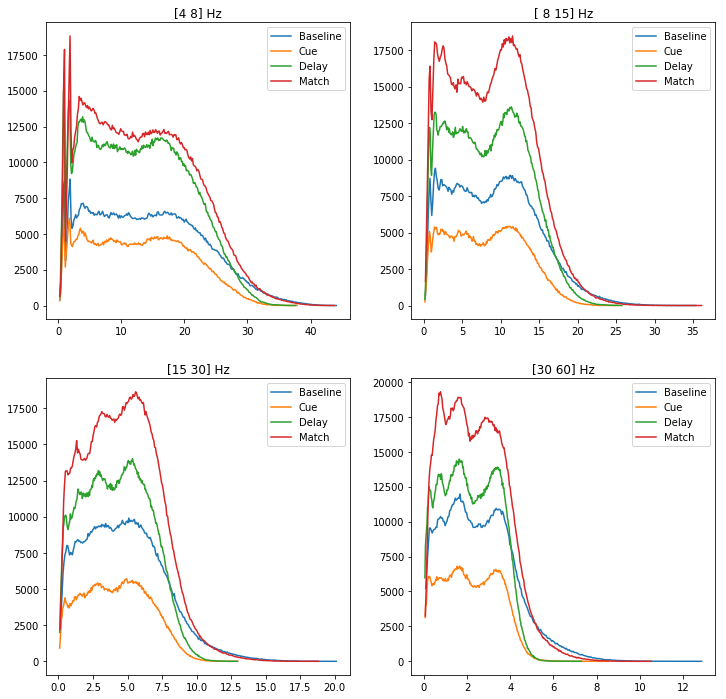

In [13]:
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1)
    n1,x1 = np.histogram(net.node_degree[:,i,net.t_baseline], 300)
    n2,x2 = np.histogram(net.node_degree[:,i,net.t_cue], 300)
    n3,x3 = np.histogram(net.node_degree[:,i,net.t_delay], 300)
    n4,x4 = np.histogram(net.node_degree[:,i,net.t_match], 300)
    plt.plot(x1[2:], n1[1:], label='Baseline')
    plt.plot(x2[2:], n2[1:], label='Cue')
    plt.plot(x3[2:], n3[1:], label='Delay')
    plt.plot(x4[2:], n4[1:], label='Match')
    plt.title(str(net.bands[i]) + ' Hz')
    plt.legend()

In [14]:
net.session_info.keys()

dict_keys(['nC', 'nP', 'nT', 'pairs', 'indt', 'fsample', 'tarray', 'channels_labels', 'dcue', 'dsm', 'stim', 'indch', 'areas', 't_cue_on', 't_cue_off', 't_match_on'])

In [15]:
net.session_info['channels_labels']

array(['1', '4', '9', '13', '16', '17', '22', '23', '26', '27', '29',
       '34', '39', '43', '54', '63', '66', '92', '95', '105', '106',
       '110', '121', '122', '127', '128', '132', '134', '135', '146',
       '148', '149', '150', '156', '161', '176', '177', '178', '183',
       '201', '203', '205', '210', '219', '221', '224', '242', '248',
       '250'], dtype='<U3')

In [16]:
net.session_info['areas']

array(['a46V', 'a24c', 'a46D', 'F7', 'a9/46D', 'a8M', 'a8r', 'a8M', 'F2',
       'F2', 'a44', 'F2', 'a8L', 'F2', 'F2', 'F1', 'a3', 'F1', 'F1', 'F1',
       'a3', 'a7B', 'a7B', 'a7B', 'Thal', 'a3', 'a7B', 'a7A', 'LIP',
       'LIP', 'a5', 'a5', 'a5', 'a7A', 'a5', 'MT', 'DP', 'DP', 'V6A',
       'DP', 'V2', 'V6A', 'V1', 'V1', 'V1', 'V2', 'V1', 'V1', 'V1'],
      dtype=object)

In [17]:
from GDa.graphics.plot_brain_sketch import plot_node_brain_sketch, plot_edge_brain_sketch

In [18]:
#for i in range(244):
#    plt.figure()
#    plot_node_brain_sketch(net.session_info['channels_labels'].astype(int), net.A[:,0,i])

In [19]:
net.node_degree.shape

(49, 4, 131760)

In [20]:
net.session_info['channels_labels'].astype(int)

array([  1,   4,   9,  13,  16,  17,  22,  23,  26,  27,  29,  34,  39,
        43,  54,  63,  66,  92,  95, 105, 106, 110, 121, 122, 127, 128,
       132, 134, 135, 146, 148, 149, 150, 156, 161, 176, 177, 178, 183,
       201, 203, 205, 210, 219, 221, 224, 242, 248, 250])

In [21]:
net.session_info['channels_labels'].astype(int).shape

(49,)

In [22]:
net.super_tensor.shape

(1176, 4, 131760)

In [23]:
'''
for i in range(244):
    if net.tarray[i] < 0:
        color = 'r'
        title = 'Baseline'
    if net.tarray[i] >= 0 and net.tarray[i] < (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'b'
        title = 'Cue'
    if net.tarray[i] >= (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000 and net.tarray[i] < (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'm'
        title = 'Delay'
    if net.tarray[i] >= (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:
        color = 'k'
        title = 'Match'
    w = net.super_tensor[:,0,i]>.7
    plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), w)
    plt.title(title)
    plt.savefig('figures/net_'+str(i)+'.png')
    plt.close()
'''    

"\nfor i in range(244):\n    if net.tarray[i] < 0:\n        color = 'r'\n        title = 'Baseline'\n    if net.tarray[i] >= 0 and net.tarray[i] < (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000:\n        color = 'b'\n        title = 'Cue'\n    if net.tarray[i] >= (net.session_info['t_cue_off'][0]-net.session_info['t_cue_on'][0])/1000 and net.tarray[i] < (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:\n        color = 'm'\n        title = 'Delay'\n    if net.tarray[i] >= (net.session_info['t_match_on'][0]-net.session_info['t_cue_on'][0])/1000:\n        color = 'k'\n        title = 'Match'\n    w = net.super_tensor[:,0,i]>.7\n    plot_edge_brain_sketch(net.session_info['pairs'], net.session_info['channels_labels'].astype(int), w)\n    plt.title(title)\n    plt.savefig('figures/net_'+str(i)+'.png')\n    plt.close()\n"

In [24]:
net.tarray

array([-0.65 , -0.635, -0.62 , -0.605, -0.59 , -0.575, -0.56 , -0.545,
       -0.53 , -0.515, -0.5  , -0.485, -0.47 , -0.455, -0.44 , -0.425,
       -0.41 , -0.395, -0.38 , -0.365, -0.35 , -0.335, -0.32 , -0.305,
       -0.29 , -0.275, -0.26 , -0.245, -0.23 , -0.215, -0.2  , -0.185,
       -0.17 , -0.155, -0.14 , -0.125, -0.11 , -0.095, -0.08 , -0.065,
       -0.05 , -0.035, -0.02 , -0.005,  0.01 ,  0.025,  0.04 ,  0.055,
        0.07 ,  0.085,  0.1  ,  0.115,  0.13 ,  0.145,  0.16 ,  0.175,
        0.19 ,  0.205,  0.22 ,  0.235,  0.25 ,  0.265,  0.28 ,  0.295,
        0.31 ,  0.325,  0.34 ,  0.355,  0.37 ,  0.385,  0.4  ,  0.415,
        0.43 ,  0.445,  0.46 ,  0.475,  0.49 ,  0.505,  0.52 ,  0.535,
        0.55 ,  0.565,  0.58 ,  0.595,  0.61 ,  0.625,  0.64 ,  0.655,
        0.67 ,  0.685,  0.7  ,  0.715,  0.73 ,  0.745,  0.76 ,  0.775,
        0.79 ,  0.805,  0.82 ,  0.835,  0.85 ,  0.865,  0.88 ,  0.895,
        0.91 ,  0.925,  0.94 ,  0.955,  0.97 ,  0.985,  1.   ,  1.015,
      

In [25]:
net.super_tensor[:,0,0].min()

0.12112201773561537

In [26]:
import networkx as nx

In [27]:
g = nx.Graph(net.A[:,:,0,0]>.7)

In [28]:
g.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48))

In [29]:
g

In [30]:
c = nx.core_number(g)

In [31]:
c.values()

dict_values([17, 27, 27, 27, 27, 27, 10, 27, 21, 27, 10, 2, 27, 27, 26, 27, 27, 27, 27, 21, 27, 9, 9, 18, 18, 21, 16, 22, 27, 27, 27, 27, 21, 27, 27, 27, 6, 21, 15, 27, 27, 27, 27, 27, 17, 27, 27, 27, 27])

Text(0.5, 1.0, 'coreness')

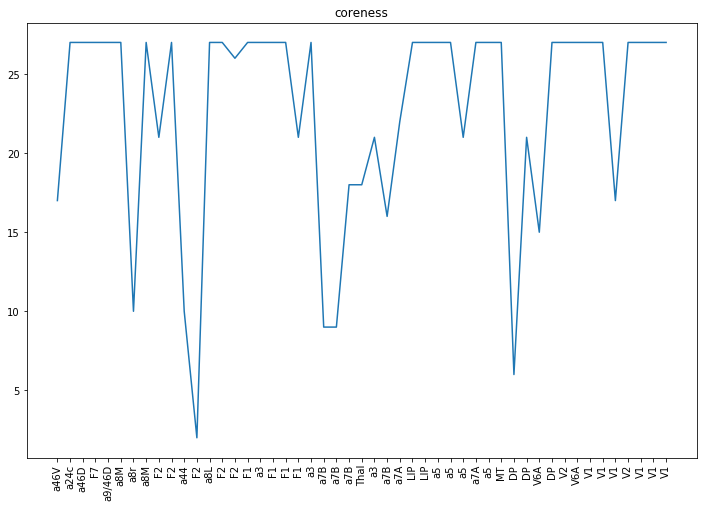

In [32]:
plt.figure(figsize=(12,8))
plt.plot(range(49), c.values())
plt.xticks(range(49), net.session_info['areas'], rotation=90)
plt.title('coreness')

In [49]:
degree = np.zeros([net.A.shape[0],net.A.shape[3]])
for t in tqdm( range(net.A.shape[3]) ):
    g = nx.Graph(net.A[:,:,1,t])
    degree[:,t] = list(dict( g.degree(weight='weight') ).values() )

100%|██████████| 131760/131760 [07:45<00:00, 282.88it/s]


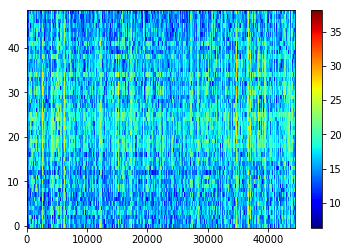

In [58]:
plt.imshow(degree[:, net.t_match], aspect='auto', cmap='jet', origin = 'lower'); plt.colorbar()

In [48]:
g = nx.Graph(net.A[:,:,1,t])
len( list(dict( g.degree(weight='weight') ).values() ) )

49

In [28]:
coreness = np.zeros([net.A.shape[0],net.A.shape[3]])
for t in range(net.A.shape[3]):
    g = nx.Graph(net.A[:,:,1,t])
    coreness[:,t] = list( nx.core_number(g, weight = 'weight').values() )

  0%|          | 0/131760 [00:00<?, ?it/s]


AttributeError: 'Graph' object has no attribute 'core_number'

In [34]:
clustering = np.zeros([net.A.shape[0],net.A.shape[3]])
for t in tqdm( range(net.A.shape[3]) ):
    g = nx.Graph(net.A[:,:,1,t])
    clustering[:,t] = list( nx.clustering(g, weight =  'weigth' ).values() )

  1%|          | 1318/131760 [05:21<8:51:16,  4.09it/s]

KeyboardInterrupt: 

In [36]:
'''
plt.figure(figsize=(12,8))
for i in range(net.session_info['nT']):
    plt.figure()
    plt.imshow(coreness[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')
    plt.savefig('figures/core_alpha_'+str(i)+'.png')
    plt.close()
'''

"\nplt.figure(figsize=(12,8))\nfor i in range(net.session_info['nT']):\n    plt.figure()\n    plt.imshow(coreness[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()\n    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')\n    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')\n    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')\n    plt.yticks(range(49), net.session_info['areas'])\n    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')\n    plt.savefig('figures/core_alpha_'+str(i)+'.png')\n    plt.close()\n"

In [37]:
'''
plt.figure(figsize=(12,8))
for i in range(net.session_info['nT']):
    plt.figure()
    plt.imshow(clustering[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'hot', origin = 'lower', vmax=1, extent=[-0.65,3.00,0,48]); plt.colorbar()
    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
    plt.yticks(range(49), net.session_info['areas'])
    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')
    plt.savefig('figures/clustering_alpha_'+str(i)+'.png')
    plt.close()
'''

"\nplt.figure(figsize=(12,8))\nfor i in range(net.session_info['nT']):\n    plt.figure()\n    plt.imshow(clustering[:,i*244:(i+1)*244], aspect = 'auto', cmap = 'hot', origin = 'lower', vmax=1, extent=[-0.65,3.00,0,48]); plt.colorbar()\n    plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')\n    plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')\n    plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')\n    plt.yticks(range(49), net.session_info['areas'])\n    plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')\n    plt.savefig('figures/clustering_alpha_'+str(i)+'.png')\n    plt.close()\n"

In [38]:
np.array(nx.core_number(g).items())

array(dict_items([(0, 1), (1, 2), (2, 4), (3, 2), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (9, 2), (10, 2), (11, 4), (12, 3), (13, 4), (14, 4), (15, 2), (16, 1), (17, 4), (18, 4), (19, 4), (20, 4), (21, 0), (22, 5), (23, 5), (24, 4), (25, 0), (26, 5), (27, 2), (28, 0), (29, 2), (30, 2), (31, 2), (32, 4), (33, 4), (34, 2), (35, 5), (36, 5), (37, 5), (38, 4), (39, 5), (40, 5), (41, 4), (42, 5), (43, 5), (44, 5), (45, 3), (46, 4), (47, 1), (48, 0)]),
      dtype=object)

Text(0.5, 1.0, 'Trial = 1, threshold = 0.7')

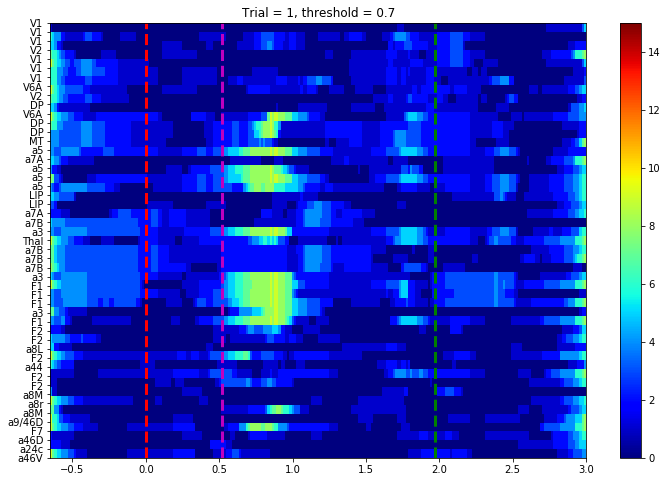

In [39]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(coreness[:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', vmax=15, extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')

Text(0.5, 1.0, 'Trial = 1, threshold = 0.7')

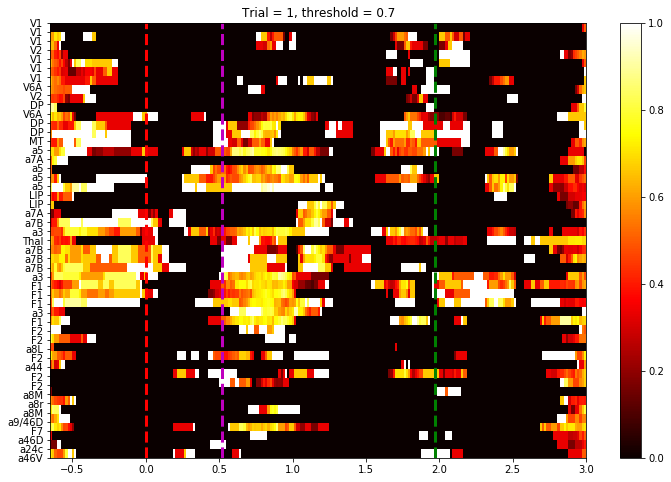

In [40]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(clustering[:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'hot', origin = 'lower', extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')

Text(0.5, 1.0, 'Trial = 1, threshold = 0.7')

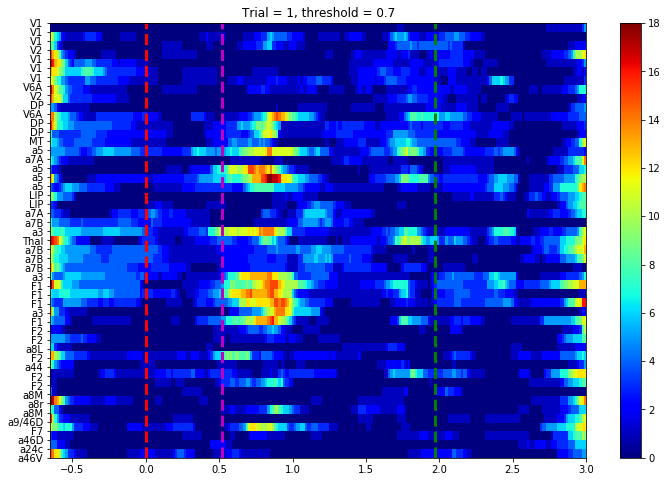

In [41]:
i=0
plt.figure(figsize=(12,8))
plt.imshow(degree[:,(i)*244:(i+1)*244], aspect = 'auto', cmap = 'jet', origin = 'lower', extent=[-0.65,3.00,0,48]); plt.colorbar()
plt.vlines(0, 0, 48, linestyle='--', linewidth = 3, color = 'r')
plt.vlines((net.session_info['t_cue_off'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'm')
plt.vlines((net.session_info['t_match_on'][i]-net.session_info['t_cue_on'][i])/1000, 0, 48, linestyle='--', linewidth = 3, color = 'g')
plt.yticks(range(49), net.session_info['areas'])
plt.title('Trial = ' + str(i+1) + ', threshold = 0.7')

In [42]:
comv = coreness.reshape(49,540,244).mean(axis = 1)

In [43]:
cmv = clustering.reshape(49,540,244).mean(axis = 1)

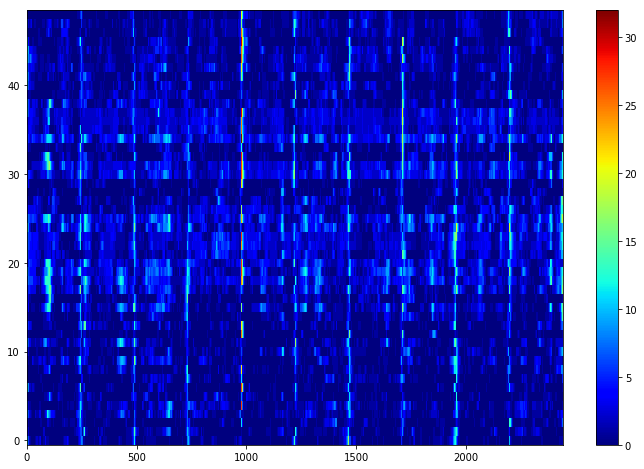

In [44]:
plt.figure(figsize=(12,8))
plt.imshow(degree[:,:2440], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [45]:
net.A.shape

(49, 49, 4, 131760)

In [46]:
len(coreness.shape)

2

In [47]:
g = nx.Graph(net.A[:,:,1,t])

In [48]:
print(clustering[:,net.t_baseline].shape)
print(clustering[:,net.t_cue].shape)
print(clustering[:,net.t_delay].shape)
print(clustering[:,net.t_match].shape)
net.super_tensor.shape

(49, 23760)
(49, 18360)
(49, 45210)
(49, 44430)


(1176, 4, 131760)

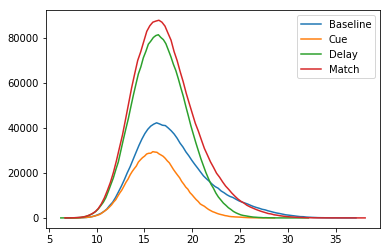

In [54]:
n1, x1 = np.histogram(degree[:,net.t_baseline].flatten(), 100)
n2, x2 = np.histogram(degree[:,net.t_cue].flatten(), 100)
n3, x3 = np.histogram(degree[:,net.t_delay].flatten(), 100)
n4, x4 = np.histogram(degree[:,net.t_match].flatten(), 100)
plt.plot(x1[1:], n1, label = 'Baseline')
plt.plot(x2[1:], n2, label = 'Cue')
plt.plot(x3[1:], n3, label = 'Delay')
plt.plot(x4[1:], n4, label = 'Match')
plt.legend()

In [36]:
G = nx.Graph()

In [37]:
edges = np.hstack( (net.session_info['pairs'], net.super_tensor[:,1,0][:, None]) )
edges = list( map(tuple, edges) ) 

In [38]:
G.add_weighted_edges_from(edges)

In [43]:
G = nx.Graph(net.A[:,:,1,0])

In [44]:
G.degree()

DegreeView({0: 48, 1: 48, 2: 48, 3: 48, 4: 48, 5: 48, 6: 48, 7: 48, 8: 48, 9: 48, 10: 48, 11: 48, 12: 48, 13: 48, 14: 48, 15: 48, 16: 48, 17: 48, 18: 48, 19: 48, 20: 48, 21: 48, 22: 48, 23: 48, 24: 48, 25: 48, 26: 48, 27: 48, 28: 48, 29: 48, 30: 48, 31: 48, 32: 48, 33: 48, 34: 48, 35: 48, 36: 48, 37: 48, 38: 48, 39: 48, 40: 48, 41: 48, 42: 48, 43: 48, 44: 48, 45: 48, 46: 48, 47: 48, 48: 48})

In [45]:
list (dict( G.degree(weight='weight') ).values() )

[30.212249446078204,
 22.738081934396178,
 22.281688650138676,
 28.660268955864012,
 27.602022237027995,
 25.451282367110252,
 29.540921973530203,
 25.53835868812166,
 21.736025798367336,
 21.819854241766734,
 25.78278820286505,
 29.177637225715443,
 21.623754823987838,
 25.238008695072494,
 22.09102119365707,
 18.72826910649019,
 25.513485472882167,
 24.277573222178034,
 24.07717522792518,
 29.010523198288865,
 25.05802189244423,
 27.814134032290895,
 26.91586980537977,
 26.730554042151198,
 30.67825122200884,
 24.44063567405101,
 25.19314317770477,
 23.181154617574066,
 21.251082136419427,
 24.15403478220105,
 18.557790136204858,
 28.746973300119862,
 21.437704164665774,
 23.23584923229646,
 22.146920828789007,
 24.762044894276187,
 24.893057733701426,
 27.70267823524773,
 29.872832544730045,
 23.54943545354763,
 28.63531723804772,
 29.392428791616112,
 27.366419027093798,
 27.149365489953198,
 30.402600935660303,
 27.866409932728857,
 22.295001868798863,
 23.905865118053043,
 16.745

In [56]:
a = list (dict( G.degree(weight='weight') ).values() )

In [57]:
b = net.node_degree[:,1,0]

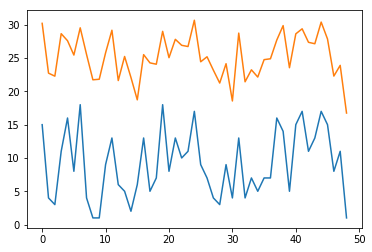

In [58]:
plt.plot(degree[:,0])
plt.plot(a)

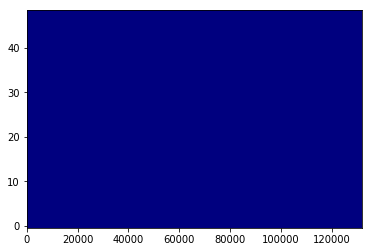

In [34]:
plt.imshow(degree, aspect = 'auto', cmap = 'jet', origin = 'lower')

In [60]:
len(net.super_tensor.shape)==4

False

In [61]:
net.super_tensor = net.reshape_trials(net.super_tensor)

3


In [62]:
net.super_tensor = net.reshape_observations(net.super_tensor)

In [63]:
net.super_tensor.reshape([1176, 4, net.session_info['nT'], len(net.tarray)]).shape

(1176, 4, 540, 244)

In [64]:
net.super_tensor.shape

(1176, 4, 131760)

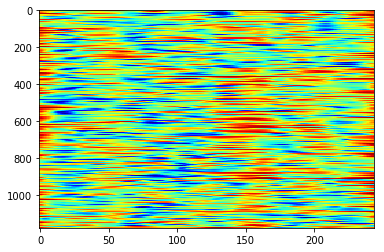

In [65]:
plt.imshow(net.super_tensor[:,0,:244], aspect='auto',cmap='jet')

In [66]:
net.super_tensor.reshape

<function ndarray.reshape>

In [67]:
net.super_tensor.shape

(1176, 4, 131760)

In [68]:
net.compute_nodes_degree(1)

100%|██████████| 131760/131760 [07:48<00:00, 281.17it/s]


In [35]:
 degree

array([[48., 48., 48., ..., 48., 48., 48.],
       [48., 48., 48., ..., 48., 48., 48.],
       [48., 48., 48., ..., 48., 48., 48.],
       ...,
       [48., 48., 48., ..., 48., 48., 48.],
       [48., 48., 48., ..., 48., 48., 48.],
       [48., 48., 48., ..., 48., 48., 48.]])